# In this tutorial, we'll go through an analysis of publicly available 1000 genomes data

## We're using the phase 3 genotypes with some mock phenotype measures for Type 2 Diabetes

### First, we'll load some packages
#### FISS -  tools for interacting with a Firecloud workspace
#### Pandas & Numpy - for printing and manipulating some of the data
#### Pprint - for pretty printing

In [1]:
%%capture
from firecloud import fiss
import pandas as pd
pd.set_option('display.max_row', 10000)
import numpy as np
from pprint import pprint


### Next, let's take a look at the workspace data model to see how many samples and participants we have.
#### Check out the data model to see how we have populated it.
#### In this case, a *participant* is a set of genotypes and a *sample* is a set of phenotypes and associated data for a single analysis.
#### Each *sample* refers to a *participant*, both in the data model and in the actual phenotypes.

In [2]:
# Take a look at the metadata that we have in the data model of our workspace.
ent_types = fiss.fapi.list_entity_types("broad-firecloud-dsde", "Notebooks-Demo-Manning-Lab").json()
for t in ent_types.keys():
    print t, "count:", ent_types[t]['count']

sample count: 2
participant count: 1


In [3]:
# The genotype filepaths are stored in the participant entity
# Here we get all of the participant metadata in json format using FISS
participant = fiss.fapi.get_entities("broad-firecloud-dsde", "Notebooks-Demo-Manning-Lab", "participant").json()[0]

In [4]:
# The filepaths are in the column 'vcf_gz' in the datamodel. Put these filepaths into a python list
vcf_files = sorted(participant['attributes']['vcf']['items'])
pprint(vcf_files[13])

u'gs://fc-fce06143-8e4d-4460-8475-a61ddea26b4b/1kg_genotypes/ALL.chr22_GRCh38.genotypes.20170504.vcf.bgz'


In [5]:
# We'll also want the phenotype file for a GWAS. This is in the sample metadata.
sample = fiss.fapi.get_entities("broad-firecloud-dsde", "Notebooks-Demo-Manning-Lab", "sample").json()[0]
pprint(sample)

{u'attributes': {u'kinship': u'gs://fc-fce06143-8e4d-4460-8475-a61ddea26b4b/1kg_kinship/1kg_GRCh38_genotypes_20170504_kinship.txt',
                 u'participant': {u'entityName': u'1kg_GRCh38_genotypes_20170504',
                                  u'entityType': u'participant'},
                 u'phenotypes': u'gs://fc-fce06143-8e4d-4460-8475-a61ddea26b4b/1kg_phenotypes/1kg_GRCh38_genotypes_20170504_demo_phenotypes.csv',
                 u'sample_ids': u'gs://fc-fce06143-8e4d-4460-8475-a61ddea26b4b/1kg_sampleids/1kg_GRCh38_genotypes_20170504_demo_phenotypes.sample.ids.txt'},
 u'entityType': u'sample',
 u'name': u'1kg_GRCh38_genotypes_20170504_demo_phenotypes'}


In [6]:
# Find the phenotype filepath under the column 'phenotypes'
phenotypes = sample['attributes']['phenotypes']
pprint(phenotypes)

u'gs://fc-fce06143-8e4d-4460-8475-a61ddea26b4b/1kg_phenotypes/1kg_GRCh38_genotypes_20170504_demo_phenotypes.csv'


### Now that we know where to find our data, let's start Hail and do some manipulation.

In [7]:
# start hail context
from hail import *
hc = HailContext(sc, log = "manning-lab-demo.log")

Running on Apache Spark version 2.0.2
SparkUI available at http://10.128.0.20:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.1-5c275cc


In [8]:
# load the genotype data
vds = (
    hc
    .import_vcf(
        vcf_files[13].strip(),
        min_partitions = 100
    )
    .split_multi()
    .sample_variants(0.01)
)


2018-05-23 14:20:20 Hail: INFO: Multiallelic variants detected. Some methods require splitting or filtering multiallelics first.
2018-05-23 14:20:20 Hail: INFO: Coerced almost-sorted dataset


In [9]:
# read the phenotype data
pheno = (
    hc
    .import_table(
       phenotypes,
        delimiter=',',
        types = {
            'sample_id': TString(), 
            'population': TString(), 
            'ancestry': TString(), 
            'sex': TString(), 
            'last_exam_age': TDouble(), 
            't2d': TInt(),
            'bmi': TDouble()
        }
    )
    .key_by(
        'sample_id'
    )
)

2018-05-23 14:20:21 Hail: INFO: Reading table with no type imputation
  Loading column `sample_id' as type `String' (user-specified)
  Loading column `population' as type `String' (user-specified)
  Loading column `ancestry' as type `String' (user-specified)
  Loading column `sex' as type `String' (user-specified)
  Loading column `last_exam_age' as type `Double' (user-specified)
  Loading column `t2d' as type `Int' (user-specified)
  Loading column `bmi' as type `Double' (user-specified)



In [10]:
# simplify some columns by reannotating the phenotype data
pheno = (
    pheno
    .annotate('t2d_bool = if (t2d == 1) true else false')
    .annotate('female_bool = if (sex == "F") true else false')
)

In [11]:
# show phenotype data
pheno_pd = pheno.to_pandas()
pheno_pd.groupby('ancestry').head()

,sample_id,population,ancestry,sex,last_exam_age,t2d,bmi,t2d_bool,female_bool
0,HG00096,GBR,EUR,M,44.395244,0,28.680759,False,False
1,HG00097,GBR,EUR,F,47.698225,0,31.456875,False,True
2,HG00099,GBR,EUR,F,65.587083,0,31.513200,False,True
3,HG00100,GBR,EUR,F,50.705084,1,26.688602,True,True
4,HG00101,GBR,EUR,M,51.292877,0,35.547491,False,False
86,HG00551,PUR,AMR,F,42.827818,0,15.261945,False,True
87,HG00553,PUR,AMR,M,58.846505,0,8.656539,False,False
88,HG00554,PUR,AMR,F,39.844074,0,7.398908,False,True
89,HG00637,PUR,AMR,M,65.475811,0,8.178434,False,False
90,HG00638,PUR,AMR,F,48.668490,0,12.447545,False,True


In [12]:
# see how many inidividuals belong to each population group
pprint(pheno.query('population.counter()'))

{u'ACB': 96L,
 u'ASW': 61L,
 u'CEU': 99L,
 u'CHB': 103L,
 u'CLM': 94L,
 u'GBR': 91L,
 u'GIH': 103L,
 u'JPT': 104L,
 u'LWK': 99L,
 u'MXL': 64L,
 u'PUR': 104L,
 u'YRI': 108L}


In [13]:
# Make a table to look at the data
(pheno.aggregate_by_key(
    [
        "Ancestry = ancestry",
        "Population = population"
    ],
    [
        "Total_Individuals = t2d.count()",
        "Controls = t2d.filter(t => t == 0).count()", 
        "Control_avg_bmi = bmi.filter(t => t2d == 0).stats().mean", 
        "Cases = t2d.filter(t => t == 1).count()", 
        "Case_avg_bmi = bmi.filter(t => t2d == 1).stats().mean"
    ]
    ).to_pandas()
)


,Ancestry,Population,Total_Individuals,Controls,Control_avg_bmi,Cases,Case_avg_bmi
0,EAS,CHB,103,89,19.977816,14,14.915133
1,AFR,ACB,96,75,14.430800,21,18.908983
2,AMR,PUR,104,87,9.903439,17,19.614393
3,AMR,MXL,64,50,9.177107,14,21.733169
4,AFR,LWK,99,77,15.110111,22,21.200686
5,EAS,JPT,104,80,20.362662,24,15.717867
6,AMR,CLM,94,74,9.425871,20,18.484332
7,EUR,GBR,91,66,30.020802,25,36.250657
8,SAS,GIH,103,83,19.411811,20,20.051811
9,AFR,YRI,108,86,14.980899,22,21.859484


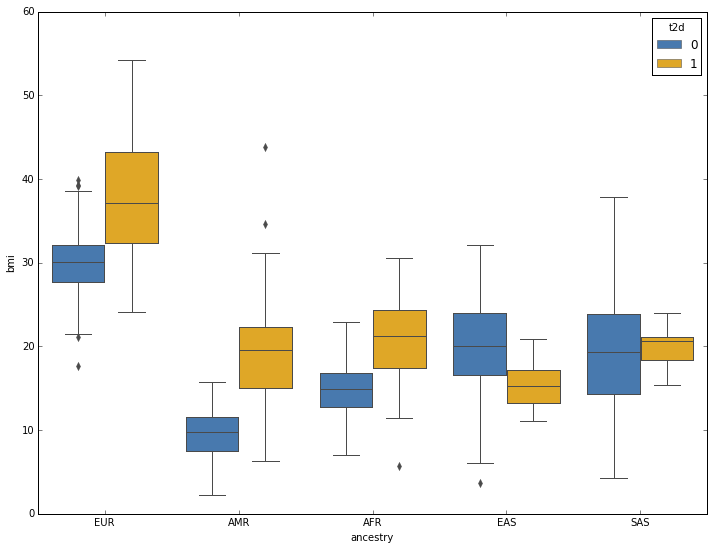

In [14]:
# Lets look at the distribution of BMI per ancestry devided by case vs control
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,9]
ax = sns.boxplot(x="ancestry", y="bmi", hue="t2d", data=pheno_pd, palette=sns.xkcd_palette(["windows blue", "amber"]))

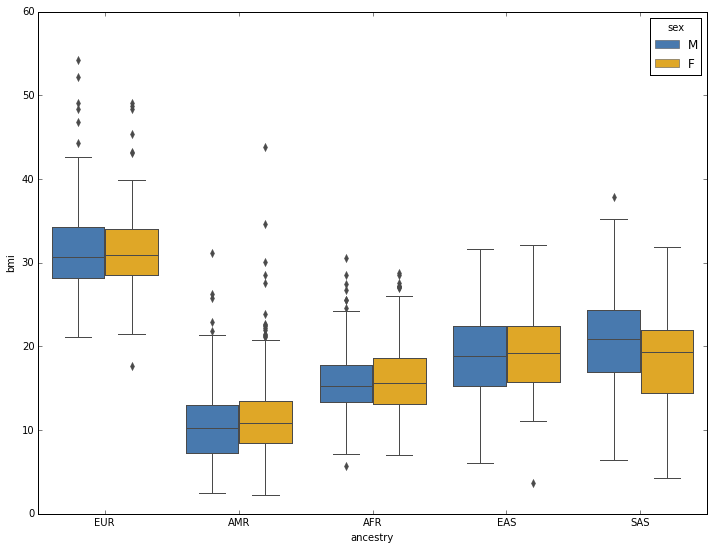

In [15]:
# distributiuon of bmi over sex
plt.rcParams["figure.figsize"] = [12,9]
ax = sns.boxplot(x="ancestry", y="bmi", hue="sex", data=pheno_pd, palette=sns.xkcd_palette(["windows blue", "amber"]))

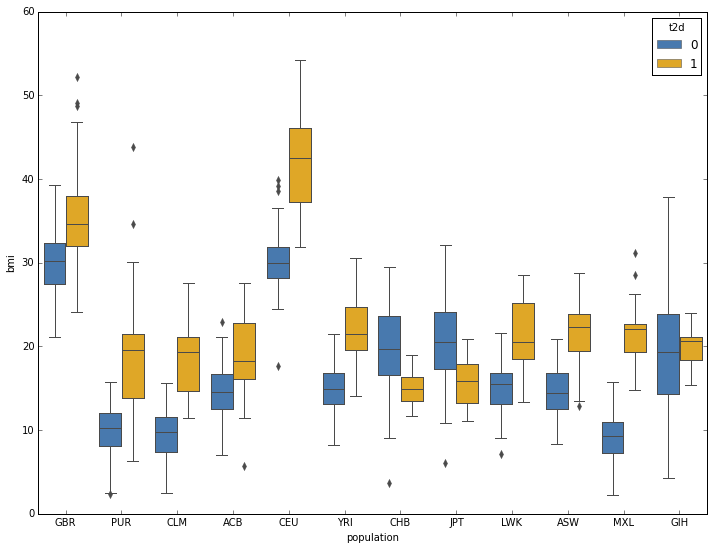

In [16]:
# "distribution of bmi per population"
plt.rcParams["figure.figsize"] = [12,9]
ax = sns.boxplot(x="population", y="bmi", hue="t2d", data=pheno_pd, palette=sns.xkcd_palette(["windows blue", "amber"]))


In [17]:
# filter the genotype data to keep only those samples with phenotype data and annotate the vds with the phenotype data
vds = (
    vds
    .filter_samples_table(
        pheno,
        keep = True
    )
    .annotate_samples_table(
        pheno,
        root = 'sa.pheno'
    )
)

### We can also look at the genotype data by generating some built-in QC measures.

In [18]:
# get some sample QC
vds = vds.sample_qc()

In [19]:
# take a look at the sample annotation schema
pprint(vds.sample_schema)

Struct{
     pheno: Struct{
         population: String,
         ancestry: String,
         sex: String,
         last_exam_age: Double,
         t2d: Int,
         bmi: Double,
         t2d_bool: Boolean,
         female_bool: Boolean
     },
     qc: Struct{
         callRate: Double,
         nCalled: Int,
         nNotCalled: Int,
         nHomRef: Int,
         nHet: Int,
         nHomVar: Int,
         nSNP: Int,
         nInsertion: Int,
         nDeletion: Int,
         nSingleton: Int,
         nTransition: Int,
         nTransversion: Int,
         dpMean: Double,
         dpStDev: Double,
         gqMean: Double,
         gqStDev: Double,
         nNonRef: Int,
         rTiTv: Double,
         rHetHomVar: Double,
         rInsertionDeletion: Double
     }
 }


In [20]:
samp_tab = vds.samples_table().to_pandas()

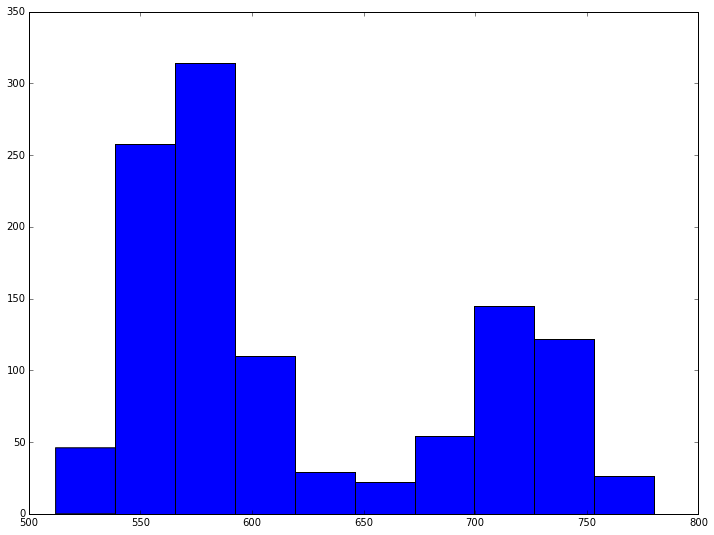

In [21]:
# See the distribution of nonRef alleles
plt.clf()
plt.hist(samp_tab['sa.qc.nNonRef'])
plt.xlabel('# Alt alleles')
plt.ylabel('# samples')
plt.show()

### We can use PCA to visualize sample relatedness

In [22]:
# subset to common variants
vds_common = (
    vds
    .filter_variants_expr(
        'min(va.info.AF) > 0.01'
    )
    .ld_prune(
        memory_per_core=256, 
        num_cores=4
    )
)

2018-05-23 14:22:25 Hail: INFO: Running LD prune with nSamples=1126, nVariants=1950, nPartitions=100, and maxQueueSize=202136.
2018-05-23 14:22:52 Hail: INFO: LD prune step 1 of 3: nVariantsKept=1530, nPartitions=100, time=27.630s
2018-05-23 14:22:54 Hail: INFO: LD prune step 2 of 3: nVariantsKept=1476, nPartitions=12, time=1.217s
2018-05-23 14:22:54 Hail: INFO: Coerced sorted dataset
2018-05-23 14:22:54 Hail: INFO: LD prune step 3 of 3: nVariantsKept=1471, time=658.432ms


In [23]:
pca = (
    vds_common
    .pca(
        'sa.pca', 
        k=5, 
        eigenvalues='global.eigen'
    )
)

2018-05-23 14:22:54 Hail: INFO: Running PCA with 5 components...


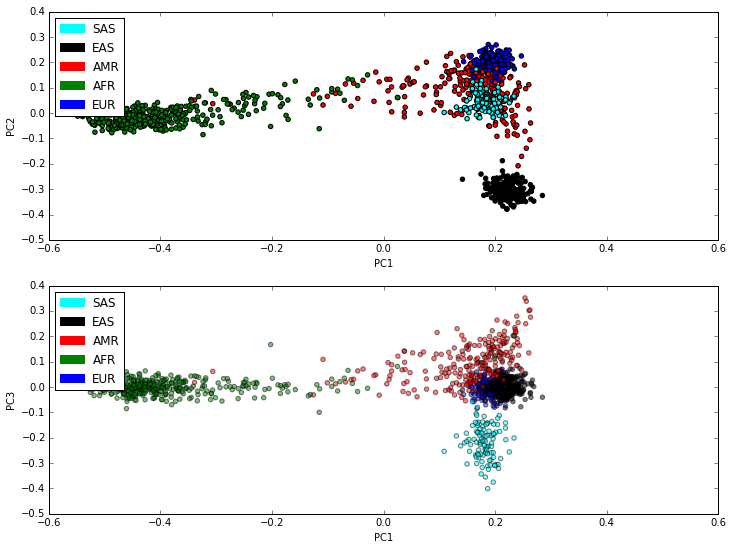

In [24]:
# visualize
import matplotlib.patches as mpatches
from collections import Counter
from math import log, isnan

plt.rcParams["figure.figsize"] = [12,9]
colors = {'AFR': 'green', 'AMR': 'red', 'EAS': 'black', 'EUR': 'blue', 'SAS': 'cyan'}
pca_table = pca.samples_table().to_pandas()

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.scatter(pca_table["sa.pca.PC1"], pca_table["sa.pca.PC2"], c = pca_table["sa.pheno.ancestry"].map(colors), alpha = .5)
ax1.set_xlim(-0.6, 0.6)
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
legend_entries = [mpatches.Patch(color=c, label=anc) for anc, c in colors.items()]
plt.legend(handles=legend_entries, loc=2)
ax2 = fig.add_subplot(212)
ax2.scatter(pca_table["sa.pca.PC1"], pca_table["sa.pca.PC3"],
            c = pca_table["sa.pheno.ancestry"].map(colors),
            alpha = .5)
ax2.set_xlim(-0.6, 0.6)
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC3")

plt.legend(handles=legend_entries, loc=2)
plt.show()


### Let's run a simple regression analysis using the first 3 PCA's and some other phenotypic information as covariates.

In [25]:
vds_common = (
    vds_common
    .annotate_samples_table(
        pca.samples_table(), 
        expr='sa.pca = table.pca'
    )
    .linreg(
        'sa.pheno.t2d_bool', 
        covariates=['sa.pca.PC1', 'sa.pca.PC2', 'sa.pca.PC3', 'sa.pheno.female_bool', 'sa.pheno.last_exam_age']
     )
)


2018-05-23 14:23:57 Hail: INFO: Running linear regression on 1126 samples with 6 covariates including intercept...


In [26]:
# This is directly taken from the Hail tutorial (https://hail.is/)
def qqplot(pvals, xMax, yMax):
    spvals = sorted(filter(lambda x: x and not(isnan(x)), pvals))
    exp = [-log(float(i) / len(spvals), 10) for i in np.arange(1, len(spvals) + 1, 1)]
    obs = [-log(p, 10) for p in spvals]
    plt.clf()
    plt.scatter(exp, obs)
    plt.plot(np.arange(0, max(xMax+1, yMax+1)), c="red")
    plt.xlabel("Expected p-value (-log10 scale)")
    plt.ylabel("Observed p-value (-log10 scale)")
    plt.xlim(0, xMax)
    plt.ylim(0, yMax)
    plt.show()

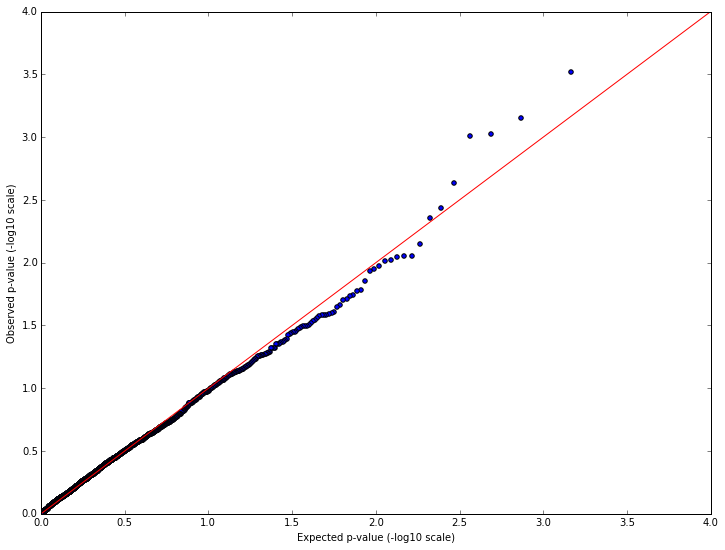

In [27]:
qqplot(vds_common.query_variants('variants.map(v => va.linreg.pval).collect()'), 4, 4)

### Finally, we'll save the results and push them back to the data model so they can be accessed through the Firecloud UI.

In [41]:
# export the association results as a tsv
date = ! date +%Y-%m-%d
bucket = 'gs://'+fiss.fapi.get_workspace("broad-firecloud-dsde", "Notebooks-Demo-Manning-Lab").json()['workspace']['bucketName']+'/demo-output/'
result_file = bucket+date[0]+'-Notebooks-Demo-Manning-Lab.association.results.tsv'
(
    vds_common
    .export_variants(result_file,
       'chr = v.locus.contig, pos = v.locus.position, ref = v.ref, alt = v.alt(), beta = va.linreg.beta, se = va.linreg.se, tstat = va.linreg.tstat, pval = va.linreg.pval')
)

2018-05-23 14:36:43 Hail: INFO: while writing:
    ./2018-05-23-Notebooks-Demo-Manning-Lab.association.results.tsv
  merge time: 365.381ms


In [38]:
# save the notebook and an HTML rendering
%notebook Notebooks-Demo-Manning-Lab.ipynb
! jupyter nbconvert --to html Notebooks-Demo-Manning-Lab.ipynb

[NbConvertApp] Converting notebook Notebooks-Demo-Manning-Lab.ipynb to html
[NbConvertApp] Writing 299208 bytes to Notebooks-Demo-Manning-Lab.html


In [33]:
# move the results, notebook, and html over to the workspace bucket
notebook_file = bucket+date[0]+'-Notebooks-Demo-Manning-Lab.ipynb'
html_file = bucket+date[0]+'-Notebooks-Demo-Manning-Lab.html'
! gsutil cp Notebooks-Demo-Manning-Lab-final.ipynb {notebook_file}
! gsutil cp Notebooks-Demo-Manning-Lab-final.html {html_file}



Copying file://Notebooks-Demo-Manning-Lab-final.ipynb [Content-Type=application/octet-stream]...
- [1 files][ 13.4 KiB/ 13.4 KiB]                                                
Operation completed over 1 objects/13.4 KiB.                                     
Copying file://Notebooks-Demo-Manning-Lab-final.html [Content-Type=text/html]...
/ [1 files][285.4 KiB/285.4 KiB]                                                
Operation completed over 1 objects/285.4 KiB.                                    
CommandException: No URLs matched: 2018-05-23-Notebooks-Demo-Manning-Lab.association.results.tsv


In [34]:
# update the data model to include the results
cols = ['entity:sample_id',
    'participant',
    'phenotypes',
    'notebook',
    'html',
    'results']


vals = [date[0]+'-Notebooks-Demo-Manning-Lab',
            '1kg_GRCh38_genotypes_20170504',
            'gs://fc-fce06143-8e4d-4460-8475-a61ddea26b4b/1kg_phenotypes/1kg_GRCh38_genotypes_20170504_demo_phenotypes.csv',
            notebook_file,
            html_file,
            result_file
       ]

entity = '\n'.join(['\t'.join(cols),'\t'.join(vals)])
fiss.fapi.upload_entities('broad-firecloud-dsde','Notebooks-Demo-Manning-Lab',entity)

<Response [200]>